In [1]:
from DarkMatter import *

Welcome to JupyROOT 6.23/01


In [13]:
import uproot
from astropy.table import Table


def getData(dwarf, runNum, ext=False):
    if ext:
        filename = DATA_DIR+"/"+dwarf+"_ext/"+str(runNum)+".anasum.root"
    else:
        filename = DATA_DIR+"/"+dwarf+str(runNum)+".anasum.root"
    anasum_file = uproot.open(filename)
    run = anasum_file["run_" + str(runNum) + ";1/stereo;1"]

    on_data = run['data_on;1']
    off_data = run['data_off;1']
    event_data = run['TreeWithEventsForCtools;1']

    on_table = Table()
    on_table['runNumber'] = on_data.arrays('runNumber').runNumber
    on_table['eventNumber'] = on_data.arrays('eventNumber').eventNumber
    on_table['MJD'] = on_data.arrays('MJD').MJD
    on_table['Time'] = on_data.arrays('Time').Time
    on_table['theta2'] = on_data.arrays('theta2').theta2
    on_table['IsGamma'] = on_data.arrays('IsGamma').IsGamma

    off_table = Table()
    off_table['runNumber'] = off_data.arrays('runNumber').runNumber
    off_table['eventNumber'] = off_data.arrays('eventNumber').eventNumber
    off_table['MJD'] = off_data.arrays('MJD').MJD
    off_table['Time'] = off_data.arrays('Time').Time
    off_table['theta2'] = off_data.arrays('theta2').theta2
    off_table['IsGamma'] = off_data.arrays('IsGamma').IsGamma

    on_mask = np.logical_and(on_table['IsGamma'] == 1, on_table['theta2'] > 0.)
    off_mask = np.logical_and(off_table['IsGamma'] == 1, off_table['theta2'] > 0.)
    clean_on_table = on_table[on_mask]
    clean_off_table = off_table[off_mask]

    on_eventNumbers = clean_on_table['eventNumber']
    off_eventNumbers = clean_off_table['eventNumber']

    table = Table()
    table['runNumber'] = event_data.arrays('runNumber').runNumber
    table['eventNumber'] = event_data.arrays('eventNumber').eventNumber 
    table['RA'] = event_data.arrays('RA').RA
    table['DEC'] = event_data.arrays('DEC').DEC
    table['EnergyS'] = event_data.arrays('EnergyS').EnergyS*1000

    on_events = []
    off_events = []
    for entry in table:
        if entry['eventNumber'] in on_eventNumbers:
            mask = clean_on_table['eventNumber'] == entry['eventNumber']
            single_event = clean_on_table[mask]
            on_events.append([entry['runNumber'], entry['EnergyS'], entry['RA'], entry['DEC'], np.sqrt(single_event['theta2'][0]), 0])
        elif entry['eventNumber'] in off_eventNumbers:
            mask = clean_off_table['eventNumber'] == entry['eventNumber']
            single_event = clean_off_table[mask]
            if entry['RA']<RA_REF:
                if entry['DEC']>DEC_REF:
                    sky = 1
                else:
                    sky = 3
            else:
                if entry['DEC']>DEC_REF:
                    sky = 2
                else:
                    sky = 4
            off_events.append([entry['runNumber'], entry['EnergyS'], entry['RA'], entry['DEC'], np.sqrt(single_event['theta2'][0]), sky])
    on_events = np.asarray(on_events)
    if ((np.average(on_events[:,2]))-RA_REF)>0.2:
        on_events[:,2]=on_events[:,2]-0.5
        print("Err", run)
    elif ((np.average(on_events[:,2]))-RA_REF)< -0.2:
        on_events[:,2]=on_events[:,2]+0.5
    return on_events.tolist(), off_events

## Get data from root files with the 'uproot' module

In [14]:
dwarf= "ursa_minor"
RA_REF = 151.767
DEC_REF = 16.082
#RA_REF = 227.297
#DEC_REF = 67.2144
#RA_REF = 260.052
#DEC_REF = 57.9153


on_table = []
off_table = []
for run in tqdm(printRunList(dwarf, ext=False)):
    on, off = getData(dwarf, run)

  0%|          | 0/181 [00:00<?, ?it/s]

FileNotFoundError: file not found

    '/Users/dtak/Research/DarkMatter/Data//ursa_minor34879.anasum.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [9]:
on

[[48865.0,
  171.46334576113398,
  151.8524471346927,
  16.100513127808224,
  0.08447690478273487,
  0.0],
 [48865.0,
  724.5103540141582,
  151.8153522294409,
  16.190875272930576,
  0.11853139784057835,
  0.0],
 [48865.0,
  297.7094342660949,
  151.70917959938012,
  15.983951190573668,
  0.11252615953977439,
  0.0],
 [48865.0,
  195.83255292873397,
  151.7086498523198,
  16.016155768497505,
  0.08626313089173461,
  0.0],
 [48865.0,
  243.1537932970943,
  151.712457938459,
  16.17933237330124,
  0.11042866182573818,
  0.0]]

In [5]:
on_selected = Table(on_table, names=["runNum", "Energy", "RA", "Dec", "theta", "sky"])
off_selected = Table(off_table, names=["runNum", "Energy", "RA", "Dec", "theta", "sky"])

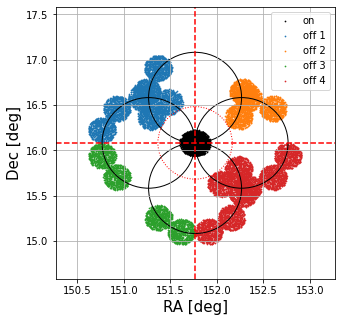

In [6]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

mask1 = (off_selected["RA"]<RA_REF)*(off_selected["Dec"]>DEC_REF)
mask1_num = 8
mask2 = (off_selected["RA"]>RA_REF)*(off_selected["Dec"]>DEC_REF)
mask2_num = 5
mask3 = (off_selected["RA"]<RA_REF)*(off_selected["Dec"]<DEC_REF)
mask3_num = 3
mask4 = (off_selected["RA"]>RA_REF)*(off_selected["Dec"]<DEC_REF)
mask4_num = 8

ax.scatter(on_selected["RA"], on_selected["Dec"], label="on", color="k", s=0.5)
ax.scatter(off_selected[mask1]["RA"], off_selected[mask1]["Dec"], label="off 1", s=0.5)
ax.scatter(off_selected[mask2]["RA"], off_selected[mask2]["Dec"], label="off 2", s=0.5)
ax.scatter(off_selected[mask3]["RA"], off_selected[mask3]["Dec"], label="off 3", s=0.5)
ax.scatter(off_selected[mask4]["RA"], off_selected[mask4]["Dec"], label="off 4", s=0.5)
ax.axhline(DEC_REF, color="r", ls="--")
ax.axvline(RA_REF, color="r", ls="--")
ax.set_xlim(RA_REF-1.5, RA_REF+1.5)
ax.set_ylim(DEC_REF-1.5, DEC_REF+1.5)
plt.xlabel(r'RA [deg]', fontsize=15)
plt.ylabel(r'Dec [deg]', fontsize=15)
plt.legend()
plt.grid()

circle = plt.Circle( (RA_REF-0.5, DEC_REF),0.5 , fill = False )
plt.gca().add_patch(circle)
circle = plt.Circle( (RA_REF+0.5, DEC_REF),0.5 , fill = False )
plt.gca().add_patch(circle)
circle = plt.Circle( (RA_REF, DEC_REF+0.5),0.5 , fill = False )
plt.gca().add_patch(circle)
circle = plt.Circle( (RA_REF, DEC_REF-0.5),0.5 , fill = False )
plt.gca().add_patch(circle)


circle = plt.Circle( (RA_REF, DEC_REF), 0.4 , fill = False, color="r", ls=":")
plt.gca().add_patch(circle)
#circle = plt.Circle( (RA_REF, DEC_REF),np.sqrt(0.02) , fill = False, color="white")
#plt.gca().add_patch(circle)


<ipython-input-10-60fb0632f254>:10: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].step(x, (y1/y), label="off 1", where="mid")
<ipython-input-10-60fb0632f254>:10: RuntimeWarning: invalid value encountered in true_divide
  ax[1].step(x, (y1/y), label="off 1", where="mid")
<ipython-input-10-60fb0632f254>:11: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].step(x, (y2/y), label="off 2", where="mid")
<ipython-input-10-60fb0632f254>:11: RuntimeWarning: invalid value encountered in true_divide
  ax[1].step(x, (y2/y), label="off 2", where="mid")
<ipython-input-10-60fb0632f254>:12: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].step(x, (y3/y), label="off 3", where="mid")
<ipython-input-10-60fb0632f254>:12: RuntimeWarning: invalid value encountered in true_divide
  ax[1].step(x, (y3/y), label="off 3", where="mid")
<ipython-input-10-60fb0632f254>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].step(x, (y4/y), label="of

(0.5, 1.2)

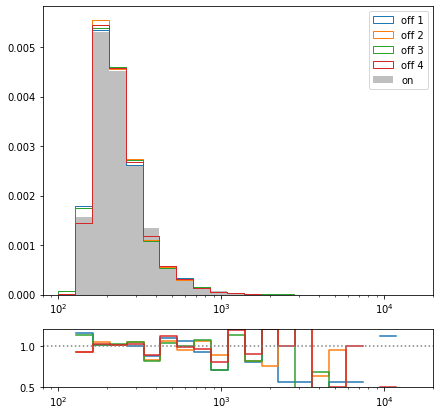

In [10]:
f, ax = plt.subplots(2,1, figsize=(7, 7), gridspec_kw={'height_ratios':[5,1]})
y1, x, etc = ax[0].hist(off_selected[mask1]["Energy"], np.logspace(2, 5, 30), density=True, histtype="step", label="off 1")
y2, x, etc = ax[0].hist(off_selected[mask2]["Energy"], np.logspace(2, 5, 30), density=True, histtype="step", label="off 2")
y3, x, etc = ax[0].hist(off_selected[mask3]["Energy"], np.logspace(2, 5, 30), density=True, histtype="step", label="off 3")
y4, x, etc = ax[0].hist(off_selected[mask4]["Energy"], np.logspace(2, 5, 30), density=True, histtype="step", label="off 4")
y, x, etc = ax[0].hist(on_selected["Energy"], np.logspace(2, 5, 30), density=True, histtype="stepfilled", alpha=0.5, color="gray", label="on")
ax[0].set_xscale("log")
ax[0].legend()
x = (x[1:]+x[:-1])/2.
ax[1].step(x, (y1/y), label="off 1", where="mid")
ax[1].step(x, (y2/y), label="off 2", where="mid")
ax[1].step(x, (y3/y), label="off 3", where="mid")
ax[1].step(x, (y4/y), label="off 4", where="mid")
ax[1].axhline(1, color="gray", ls=":")
ax[1].set_xscale("log")
ax[0].set_xlim(80, 2e4)
ax[1].set_xlim(80, 2e4)
ax[1].set_ylim(0.5, 1.2)

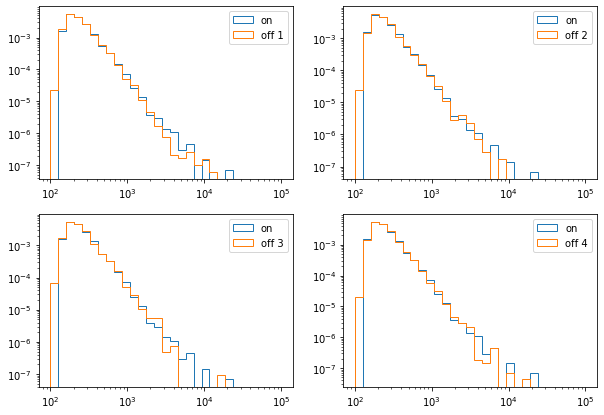

In [11]:
f, ax = plt.subplots(2,2, figsize=(10, 7))
ax[0][0].hist(on_selected["Energy"], np.logspace(2, 5, 30), density=True, histtype="step", label="on")
ax[0][0].hist(off_selected[mask1]["Energy"], np.logspace(2, 5, 30), density=True, histtype="step", label="off 1")
ax[0][1].hist(on_selected["Energy"], np.logspace(2, 5, 30), density=True, histtype="step", label="on")
ax[0][1].hist(off_selected[mask2]["Energy"], np.logspace(2, 5, 30), density=True, histtype="step", label="off 2")
ax[1][0].hist(on_selected["Energy"], np.logspace(2, 5, 30), density=True, histtype="step", label="on")
ax[1][0].hist(off_selected[mask3]["Energy"], np.logspace(2, 5, 30), density=True, histtype="step", label="off 3")
ax[1][1].hist(on_selected["Energy"], np.logspace(2, 5, 30), density=True, histtype="step", label="on")
ax[1][1].hist(off_selected[mask4]["Energy"], np.logspace(2, 5, 30), density=True, histtype="step", label="off 4")

for i in range(2):
    for j in range(2):
        ax[i][j].set_xscale("log")
        ax[i][j].set_yscale("log")
        ax[i][j].legend()